PART 1: EXECUTION

We first obtained the fall3d.res.nc file using the nebula machine. We imported the different needed files and we executed the two following commands to obtain the results of the simulation:
       "mpirun -n 4 /binaries/Fall3d.r8.x SetTgsd fall3d.inp 2 2 1"
       "mpirun -n 4 /binaries/Fall3d.r8.x All fall3d.inp 2 2 1"
. With this we obtained the file fall3d.res.nc which was the nc file with the results of the simulation.

PART 2: VISUALIZATION OF THE RESULTS OF THE EXECUTION 

In [52]:
#To compute the impact of the ash and SO2 on the flight we start importing the 
#needed libraries.
import numpy as np
import json
import xarray as xr
from datetime import datetime
import netCDF4
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interpn

#We then import the nc file and save it as a dataset inside the atm variable.
atm = xr.open_dataset("fall3.res.nc")


In [53]:
def iso_to_unix(iso_time):
    iso_time = iso_time.split('.')[0]
    dt = datetime.strptime(iso_time, "%Y-%m-%dT%H:%M:%S")
    unix_time = dt.timestamp()
    return unix_time

#We extract the different variables inside the dataset and save them in 
#different lists. With the function iso_to_unix() we change the time format of 
#the time list.

tephra = atm["tephra_fl"].values.tolist()
SO2 = atm["SO2_fl"].values.tolist()
lat = np.array(atm["lat"])
lon = np.array(atm["lon"])
hei = np.array(30.48*atm["fl"])
time = [iso_to_unix(str(i)) for i in np.array(atm["time"])]

In [54]:
#We load the flights data and save them in three different variables.

with open('/content/drive/MyDrive/HA-LWA_WZZ1897.json','r') as f:
    file1 = json.loads(f.read())
with open('/content/drive/MyDrive/HA-LWA_WZZ1898.json','r') as f:
    file2 = json.loads(f.read())
with open('/content/drive/MyDrive/HA-LWA_WZZ6269.json','r') as f:
    file3 = json.loads(f.read())

data1, data2, data3 = file1['data'], file2['data'], file3['data']
flight1, flight2, flight3 = data1['flight'], data2['flight'], data3['flight']


In [55]:
def x_round(x):
  return round(x*4)/4

def hei_round(y):
  return round(y/50)*50

#We transform the flight data onto a pandas regular dataset to make the work 
#easier. We create a new column with the flight height in fl units. Finally, we 
#round (with the x_round and hei_round functions) the values of latitude, 
#longitude and altitude (in fl) to the same precision degree as the values in 
#the fall3d.res.nc file so that they match.

route1, route2, route3 = pd.json_normalize(flight1, record_path=['track']), pd.json_normalize(flight2, record_path=['track']), pd.json_normalize(flight3, record_path=['track'])
columns = ['latitude','longitude', 'altitude.meters','timestamp']
route1, route2, route3 = route1.loc[:,columns], route2.loc[:,columns], route3.loc[:,columns]
route1[['latitude','longitude']], route2[['latitude','longitude']], route3[['latitude','longitude']] = route1[['latitude','longitude']].apply(x_round), route2[['latitude','longitude']].apply(x_round), route3[['latitude','longitude']].apply(x_round)
route1['altitude.fl'], route2['altitude.fl'], route3['altitude.fl'] = route1['altitude.meters']/30.48, route2['altitude.meters']/30.48, route3['altitude.meters']/30.48
route1[['altitude.fl']], route2[['altitude.fl']], route3[['altitude.fl']] = route1[['altitude.fl']].apply(hei_round), route2[['altitude.fl']].apply(hei_round), route3[['altitude.fl']].apply(hei_round) 

In [56]:
#After sudying the way in which the data of the .nc file is we compute different
#functions that will return the index corresponding to a time, latitude, 
#longitude or height value. With this we will be able to find the concentration
#of ash or SO2 for a combination of a flight latitude, longitude, time and 
#height.

def lat_index(lat):
  return (lat-54)*4

def lon_index(lon):
  return (lon+32)*4

def fl_index(fl):
  return fl/50-1

def time_index(time):
  return (time-1568073774)/(15*60)

In [57]:
#We now define two function that return the concentration of ash or SO2 for a 
#given set of indexes.

def atm_ash(time, lat, lon, height):
  time, lat, lon, height = int(time), int(lat), int(lon), int(height)
  if ((lat < 0 )|(lat > 80)|(lon < 0 )|(lon > 80)|(height < 0 )|(height > 7)|(time < 0 )|(time > 224)):
    return 0
  else:
    return atm['tephra_fl'][time, height, lat, lon].astype(float)

def atm_so2(time, lat, lon, height):
  time, lat, lon, height = int(time), int(lat), int(lon), int(height)
  if ((lat < 0 )|(lat > 80)|(lon < 0 )|(lon > 80)|(height < 0 )|(height > 7)|(time < 0 )|(time > 224)):
    return 0
  else:
    return atm['SO2_fl'][time, height, lat, lon].astype(float)

In [58]:
#We create four new columns of the dataset with the corresponding indexes for 
#each given value of time, latitude, longitude and height.
route1['lat_index'], route1['lon_index'], route1['time_index'], route1['hei_index'] = route1['latitude'].apply(lat_index).astype(int), route1['longitude'].apply(lon_index).astype(int), route1['timestamp'].apply(time_index).astype(int), route1['altitude.fl'].apply(fl_index).astype(int)
route2['lat_index'], route2['lon_index'], route2['time_index'], route2['hei_index'] = route2['latitude'].apply(lat_index).astype(int), route2['longitude'].apply(lon_index).astype(int), route2['timestamp'].apply(time_index).astype(int), route2['altitude.fl'].apply(fl_index).astype(int)
route3['lat_index'], route3['lon_index'], route3['time_index'], route3['hei_index'] = route3['latitude'].apply(lat_index).astype(int), route3['longitude'].apply(lon_index).astype(int), route3['timestamp'].apply(time_index).astype(int), route3['altitude.fl'].apply(fl_index).astype(int)

In [59]:
#Once we have all this we create two new columns corresponding to the ash and 
#SO2 concentration at each point of the flight.
route1['ash'] = route1.apply(lambda x: atm_ash(x['time_index'], x['lat_index'], x['lon_index'], x['hei_index']), axis=1)
route1['so2'] = route1.apply(lambda x: atm_so2(x['time_index'], x['lat_index'], x['lon_index'], x['hei_index']), axis=1)

route2['ash'] = route2.apply(lambda x: atm_ash(x['time_index'], x['lat_index'], x['lon_index'], x['hei_index']), axis=1)
route2['so2'] = route2.apply(lambda x: atm_so2(x['time_index'], x['lat_index'], x['lon_index'], x['hei_index']), axis=1)

route3['ash'] = route3.apply(lambda x: atm_ash(x['time_index'], x['lat_index'], x['lon_index'], x['hei_index']), axis=1)
route3['so2'] = route3.apply(lambda x: atm_so2(x['time_index'], x['lat_index'], x['lon_index'], x['hei_index']), axis=1)


In [60]:
#We change the concentration values to floats so that we can graphicate them.
route1['ash'], route1['so2'] = route1['ash'].astype(float), route1['so2'].astype(float)
route2['ash'], route2['so2'] = route2['ash'].astype(float), route2['so2'].astype(float)
route3['ash'], route3['so2'] = route3['ash'].astype(float), route3['so2'].astype(float)

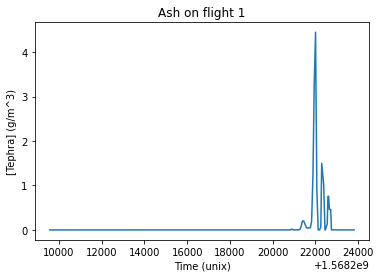

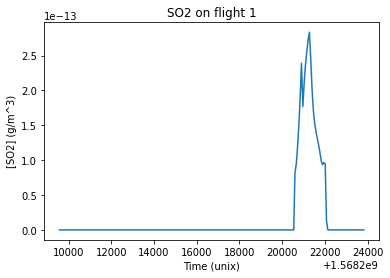

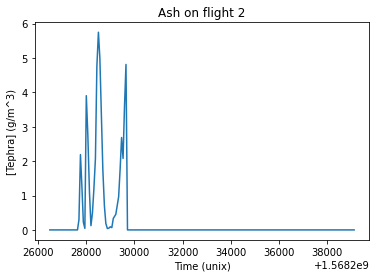

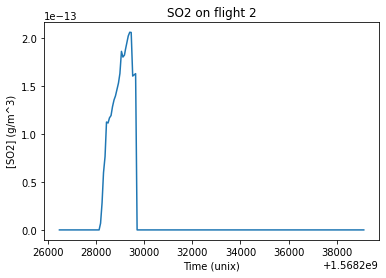

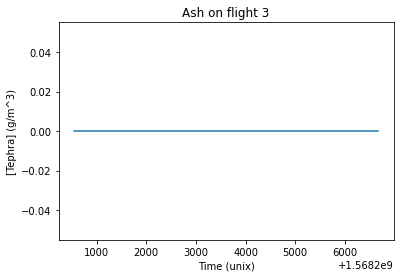

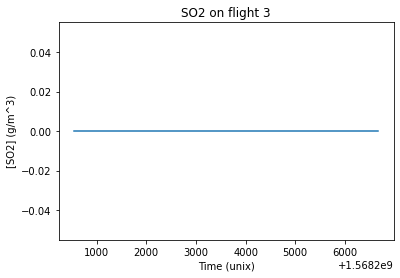

In [61]:
#We finally plot the concentration of ash and SO2 during the flights.

plt.plot(route1['timestamp'], route1['ash'])
plt.title("Ash on flight 1")
plt.xlabel("Time (unix)")
plt.ylabel("[Tephra] (g/m^3)")
plt.show()
plt.plot(route1['timestamp'], route1['so2'])
plt.title("SO2 on flight 1")
plt.xlabel("Time (unix)")
plt.ylabel("[SO2] (g/m^3)")
plt.show()
plt.plot(route2['timestamp'], route2['ash'])
plt.title("Ash on flight 2")
plt.xlabel("Time (unix)")
plt.ylabel("[Tephra] (g/m^3)")
plt.show()
plt.plot(route2['timestamp'], route2['so2'])
plt.title("SO2 on flight 2")
plt.xlabel("Time (unix)")
plt.ylabel("[SO2] (g/m^3)")
plt.show()
plt.plot(route3['timestamp'], route3['ash'])
plt.title("Ash on flight 3")
plt.xlabel("Time (unix)")
plt.ylabel("[Tephra] (g/m^3)")
plt.show()
plt.plot(route3['timestamp'], route3['so2'])
plt.title("SO2 on flight 3")
plt.xlabel("Time (unix)")
plt.ylabel("[SO2] (g/m^3)")
plt.show()

In [62]:
#We finally compute the total amount of ash and SO2 that each flight has 
#travessed.
ash_flight1 = sum(route1['ash'])
print('Total ash travessed by flight 1: ' + str(ash_flight1))
so2_flight1 = sum(route1['so2'])
print('Total so2 travessed by flight 1: ' + str(so2_flight1))
ash_flight2 = sum(route2['ash'])
print('Total ash travessed by flight 1: ' + str(ash_flight2))
so2_flight2 = sum(route2['so2'])
print('Total so2 travessed by flight 1: ' + str(so2_flight2))
ash_flight3 = sum(route3['ash'])
print('Total ash travessed by flight 1: ' + str(ash_flight3))
so2_flight3 = sum(route3['so2'])
print('Total so2 travessed by flight 1: ' + str(so2_flight3))

Total ash travessed by flight 1: 16.496074528695367
Total so2 travessed by flight 1: 3.9858249722766025e-12
Total ash travessed by flight 1: 54.4255354526917
Total so2 travessed by flight 1: 3.3381053195178273e-12
Total ash travessed by flight 1: 0.0
Total so2 travessed by flight 1: 0.0


In [63]:
#We create new datasets with the information we want to extract
columns2 = ['latitude','longitude', 'altitude.meters','timestamp', 'ash', 'so2']
route11 = route1.loc[:, columns2]
route22 = route2.loc[:, columns2]
route33 = route3.loc[:, columns2]

In [65]:
#We extract a csv file with the information of each flight
route11.to_csv('route1.csv', index = False)
route22.to_csv('route2.csv', index = False)
route33.to_csv('route3.csv', index = False)